In [1]:
#Dev

import pandas as pd
# this part needed for mac
# import pymysql
# pymysql.install_as_MySQLdb()
############################
import seaborn as sns
from mysql.connector import MySQLConnection, Error
from XML2MySQL import connect
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
%matplotlib inline

class MySQL2PandasDF:
    '''
    Takes the string connection elements of a MySQL database as input
    Class should only be initialized once - container holds database connection upon init
        All database tables are stored as Pandas DataFrames when returning class instance
        Allows a user to query MySQL normally and return a dataframe of the search results
        Stores user query history and optionally allows user to give each query a unique identifier
    '''
    def __init__(self,host,db,user,password):
        
        self.host = host
        connection_string = 'mysql+mysqldb://'+user+':'+password+'@'+host+'/'+db
        self.query_connection = create_engine(connection_string)
        try:
            self.db_connection = MySQLConnection(
                                        host = host,
                                        database = db,
                                        user = user,
                                        password = password)
            if self.db_connection.is_connected():
                print('Connection to MySQL database ' + db + ' successful.')
        except Error:
            print('Error connecting to database ' + db)
            print(Error)
            
        self.source = dict()
        self.history = dict()
        self.plots = dict()
    
    def db2df(self, db_connection=None):
        """
        Sets self.source, an entire database as a dictionary of pandas DataFrames accessible by table name keys
        Optionally takes a MySQLConnection object as input with the db_connection parameter
        :params: (MySQLConnection object)
        :return: {Table: pd.DataFrame}
        """
        if db_connection is None:
            pass
        else:
            self.db_connection = db_connection
        cursor = self.db_connection.cursor()
        cursor.execute("SHOW TABLES")
        rows = cursor.fetchall()
        self.source = dict()
        for dummy_table_name in rows:
            self.source[dummy_table_name[0]] = pd.read_sql_table(dummy_table_name[0],self.query_connection)
        cursor.close()

    
    def query_mysql(self, query, title):
        """
        Query a MySQL database and return a pandas DataFrame
        Class tracks user history using a dictionary
        User must provide question title as it is the key for the DataFrame returned
        :params: MySQL query, title
        :return: {Query Title: pd.DataFrame}, DataFrame
        """
        if str(type(title)) != "<class 'str'>":
            title = input('Title must be be a string: ')
        else:
            df = pd.read_sql(query,self.query_connection)
            self.history[title] = df
        return df
            
    def plotdf(self, plot, title):
        """
        Plot a pd.series as a given plot title
        Class tracks plot history
        User must provide plot title as it is key for DataFrame returned
        :params: Seaborn or Matplotlibe object, plot title
        :return: {Plot Title: plot}, plot
        """
        if str(type(title)) != "<class 'str'>":
            title = input('Title must be be a string: ')
        else:
            self.plots[title] = plot
        return plot

# Init Session Object

In [2]:
session = MySQL2PandasDF(host = 'localhost', db = 'stackexchange_travel', user = 'root', password = 'F0xyrules30')

Connection to MySQL database stackexchange_travel successful.


## db2df method parses the entirety of a database to dict of pandas dfs

In [3]:
session.db2df()

C:\Users\jeffe\Anaconda3\lib\site-packages\sqlalchemy\dialects\mysql\base.py:1546: Warning: (1287, "'@@tx_isolation' is deprecated and will be removed in a future release. Please use '@@transaction_isolation' instead")
  cursor.execute('SELECT @@tx_isolation')


Underlying structure is a dictionary with the following format:

{Table Name: df}

In [4]:
# tables in our dictionary

session.source.keys()

dict_keys(['badges', 'comments', 'posthistory', 'postlinks', 'posts', 'tags', 'users', 'votes'])

## Head of every table in database

In [5]:
session.source['badges'].head()

,index,class,Date,id,Name,TagBased,userId
0,0,3,2011-06-21 20:16:49,1,Autobiographer,False,2
1,1,3,2011-06-21 20:16:49,2,Autobiographer,False,3
2,2,3,2011-06-21 20:16:49,3,Autobiographer,False,4
3,3,3,2011-06-21 20:21:49,4,Autobiographer,False,6
4,4,3,2011-06-21 20:21:49,5,Autobiographer,False,8


In [6]:
session.source['comments'].head()

,index,CreationDate,Id,PostId,score,Text,UserDisplayName,userId
0,0,2011-06-21T20:25:14.257,1,1,0,To help with the cruise line question: Where a...,None,12.0
1,1,2011-06-21T20:27:35.300,2,1,0,"Toronto, Ontario. We can fly out of anywhere t...",None,9.0
2,2,2011-06-21T20:32:23.687,3,1,3,"""Best"" for what? Please read [this page](http...",None,20.0
3,3,2011-06-21T20:42:08.330,9,25,0,"Are you in the UK? If so, would be helpful to ...",None,30.0
4,4,2011-06-21T20:44:09.990,12,26,3,"Where are you starting from, and what sort of ...",None,26.0


In [7]:
session.source['posthistory'].head()

,index,Comment,CreationDate,Id,PostHistoryTypeId,PostID,RevisionGUID,Text,UserDisplayName,UserId
0,0,None,2011-06-21T20:19:34.730,1,2,1,1e04af17-3bdb-4263-aa46-97ee7fb1b0b6,My finance and myself are looking for a good C...,None,9.0
1,1,None,2011-06-21T20:19:34.730,2,1,1,1e04af17-3bdb-4263-aa46-97ee7fb1b0b6,What's the best Caribbean cruise for October,None,9.0
2,2,None,2011-06-21T20:19:34.730,3,3,1,1e04af17-3bdb-4263-aa46-97ee7fb1b0b6,<caribbean><cruising><vacations>,None,9.0
3,3,None,2011-06-21T20:22:33.760,4,2,2,58500a29-b9ed-4802-9934-c173ce362758,"This was one of our definition questions, but ...",None,13.0
4,4,None,2011-06-21T20:22:33.760,5,1,2,58500a29-b9ed-4802-9934-c173ce362758,How can I find a guide that will take me safel...,None,13.0


In [8]:
session.source['postlinks'].head()

,index,CreationDate,Id,LinkTypeId,PostId,RelatedPostId
0,0,2011-06-21 20:49:20,168,1,28,25
1,1,2011-06-21 22:55:01,1304,1,110,10
2,2,2011-06-22 11:58:40,2930,1,203,185
3,3,2011-06-22 12:32:01,2981,1,189,105
4,4,2011-06-22 20:56:21,3507,1,226,185


In [9]:
session.source['posts'].head()

,index,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,Id,...,LastEditorDisplayName,LastEditorUserId,OwnerDisplayName,OwnerUserId,ParentId,PostTypeId,Score,Tags,Title,ViewCount
0,0,393,4,<p>My fiancée and I are looking for a good Car...,2013-02-25T23:52:47.953,4,NaT,2011-06-21T20:19:34.730,NaN,1,...,None,101.0,None,9.0,NaN,1,8,<caribbean><cruising><vacations>,What are some Caribbean cruises for October?,419.0
1,1,None,7,"<p>This was one of our definition questions, b...",None,4,NaT,2011-06-21T20:22:33.760,5.0,2,...,None,13.0,None,13.0,NaN,1,32,<guides><extreme-tourism><amazon-river><amazon...,How can I find a guide that will take me safel...,1399.0
2,2,None,None,<p>One way would be to go through an Adventure...,None,2,NaT,2011-06-21T20:24:28.080,NaN,3,...,None,NaN,None,9.0,2.0,2,12,None,None,NaN
3,3,None,1,<p>Singapore Airlines has an all-business clas...,None,1,NaT,2011-06-21T20:24:57.160,NaN,4,...,None,693.0,None,24.0,NaN,1,8,<loyalty-programs><routes><ewr><singapore-airl...,Does Singapore Airlines offer any reward seats...,243.0
4,4,770,5,<p>Another definition question that interested...,None,0,NaT,2011-06-21T20:25:56.787,2.0,5,...,None,101.0,None,13.0,NaN,1,14,<romania><transportation>,What is the easiest transportation to use thro...,395.0


In [10]:
session.source['tags'].head()

,index,Count,ExcerptPostId,Id,TagName,WikiPostId
0,0,104,2138.0,1,cruising,2137.0
1,1,43,357.0,2,caribbean,356.0
2,2,43,319.0,4,vacations,318.0
3,3,8,14548.0,6,amazon-river,14547.0
4,4,100,1792.0,8,romania,1791.0


In [11]:
session.source['users'].head()

,index,AboutMe,accountid,age,CreationDate,DisplayName,downvotes,Id,LastAccessDate,Location,ProfileImageUrl,reputation,upvotes,Views,WebsiteUrl
0,0,"<p>Hi, I'm not really a person.</p>\n\n<p>I'm ...",-1.0,NaN,2011-06-21T15:16:44.253,Community,12646,-1,2011-06-21T15:16:44.253,on the server farm,None,1,2472,0,http://meta.stackexchange.com/
1,1,<p>Developer on the Stack Overflow team. Find...,2.0,40.0,2011-06-21T20:10:03.720,Geoff Dalgas,0,2,2016-05-29T01:18:20.767,"Corvallis, OR",None,101,1,31,http://stackoverflow.com
2,2,"<p>I am the <a href=""http://stackoverflow.com/...",7598.0,32.0,2011-06-21T20:11:02.490,Nick Craver,0,3,2015-09-14T12:03:40.247,"Winston-Salem, NC",https://i.stack.imgur.com/nGCYr.jpg?s=128&g=1,101,1,14,https://nickcraver.com/blog/
3,3,"<p>co-founder of <a href=""https://airtable.com...",1998.0,31.0,2011-06-21T20:12:21.223,Emmett,0,4,2013-03-01T22:30:26.790,"San Francisco, CA",https://i.stack.imgur.com/d1oHX.jpg?s=128&g=1,101,1,10,http://minesweeperonline.com
4,4,"<p><a href=""http://blog.stackoverflow.com/2010...",29738.0,NaN,2011-06-21T20:15:31.410,Kevin Montrose,0,5,2017-02-07T02:24:34.733,"New York, NY, United States",None,101,1,11,http://kevinmontrose.com/


In [12]:
session.source['votes'].head()

,index,BountyAmount,CreationDate,Id,PostId,UserId,VoteTypeId
0,0,NaN,2011-06-21,1,1,NaN,2
1,1,NaN,2011-06-21,2,1,NaN,2
2,2,NaN,2011-06-21,3,2,NaN,2
3,3,NaN,2011-06-21,4,3,NaN,2
4,4,NaN,2011-06-21,5,5,13.0,5


# Data Exploration: US Sentiment

### Now we can begin asking questions about our data

Using either MySQL syntax or the built in functionality/flexability of pandas DataFrames

For example, lets examine the sentiment towards the USA as a travel destination in this forum

In [13]:
# first we must strip the tags from their ...well... tags
# appended to the original source table as 'stripped_Tags'

session.source['posts']['stripped_Tags'] = session.source['posts']['Tags'].str.replace('<','').str.replace('>',' ')

In [31]:
# lets isolate all posts that have a usa tag

usa = session.source['posts'][session.source['posts']['stripped_Tags'].str.contains('usa', na=False)]
usa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 27 to 72162
Data columns (total 23 columns):
index                    3391 non-null int64
AcceptedAnswerId         1262 non-null object
AnswerCount              3391 non-null object
Body                     3391 non-null object
ClosedDate               829 non-null object
CommentCount             3391 non-null object
CommunityOwnedDate       1 non-null datetime64[ns]
CreationDate             3391 non-null object
FavoriteCount            785 non-null float64
Id                       3391 non-null int64
LastActivityDate         3391 non-null datetime64[ns]
LastEditDate             2903 non-null object
LastEditorDisplayName    38 non-null object
LastEditorUserId         2874 non-null float64
OwnerDisplayName         42 non-null object
OwnerUserId              3356 non-null float64
ParentId                 0 non-null float64
PostTypeId               3391 non-null int64
Score                    3391 non-null int64
Tags         

# Data Cleaning: Parse HTML

Our data for the post body still contains all the raw html included - lets use BeautifulSoup to parse the contents of the html tags

In [15]:
from bs4 import BeautifulSoup
usa['Body'] = [BeautifulSoup(text,'lxml').get_text() for text in usa['Body']]

C:\Users\jeffe\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [16]:
usa['Body'][27]

'The next time family from overseas comes to visit me in the USA, I would like for them to see the major sites in the USA.\nIs there such a thing as a prepaid flying tour of the USA?\n'

Post body still contains those annoying \n line breaks - lets use a simple str replace to get rid of them

In [17]:
usa['Body'] = usa['Body'].str.replace('\n', ' ')

C:\Users\jeffe\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [18]:
usa['Body'][27]

'The next time family from overseas comes to visit me in the USA, I would like for them to see the major sites in the USA. Is there such a thing as a prepaid flying tour of the USA? '

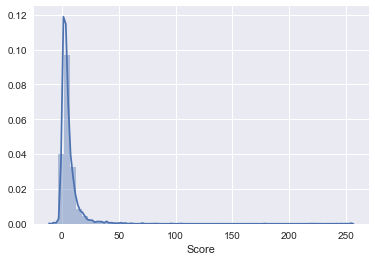

In [19]:
# plotting scores for each usa related post

piccap3 = 'Post Scores for Posts Tagged USA'

session.plotdf(sns.distplot(session.source['posts'][session.source['posts']['stripped_Tags'].str.contains('usa', na=False)]['Score']),piccap3)

Post scores for USA tagged posts seem to have a positive skew, but are still relatively low. Lets do some further data exploration to isolate relevant statistical moments from the data.

In [20]:
print('Mean: '+str(session.source['posts'][session.source['posts']['stripped_Tags'].str.contains('usa', na=False)]['Score'].mean()))
print('Median: '+str(session.source['posts'][session.source['posts']['stripped_Tags'].str.contains('usa', na=False)]['Score'].median()))
print('Mode: '+str(session.source['posts'][session.source['posts']['stripped_Tags'].str.contains('usa', na=False)]['Score'].mode()))

Mean: 6.104393984075494
Median: 4.0
Mode: 0    2
dtype: int64


Median is more likely a better measure, as it is not skewed as much as the mean - lets make a box and whisker plot to confirm this

(-5, 15)

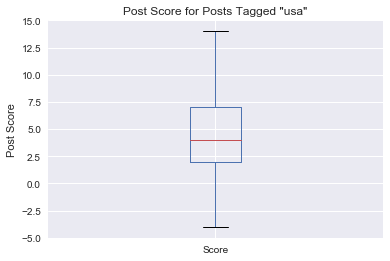

In [21]:
session.source['posts'][session.source['posts']['stripped_Tags'].str.contains('usa', na=False)]['Score'].plot(kind='box')
plt.title('Post Score for Posts Tagged "usa"')
plt.xlabel('')
plt.ylabel('Post Score')
plt.ylim((-5,15))

It's difficult to tell, but post Score appears to be more or less symmetrical about the median. Let's go ahead and use the median value as the cutoff for performing sentiment analysis on the contents of the post:

* Score >= 4 -> Good
* Score < 4 -> Bad

For fun lets find the highest score and the lowest score in the post history:

In [22]:
# highest score
usa[usa['Score'] == usa['Score'].max()]['Body'][27472]

'I have come across a few situations when an American will say something like "We should have lunch some time" or "Let\'s have lunch some time." Or "you should come down to visit me in D.C. (or Miami or wherever"); we have great museums (or Cuban food or whatever)." It turns out though that more often than not they don\'t really mean it. Because if I then immediately follow up with "Oh how about lunch tomorrow?" or "Oh will you be in Miami in early December? I could come by then.", they usually start getting evasive and awkward, and back out of what seemed like an invitation that they just made. How can I tell when Americans genuinely/literally mean what they say, especially in the aforementioned situations?  Perhaps this is common not just to American culture but also to some other cultures across the world, but it was (and still is) very puzzling to me and I am still trying to figure it out. '

In [23]:
# Lowest score
usa[usa['Score'] == usa['Score'].min()]['Body'][11618]

"What is the local culture of USA, like in South Africa, we have isiXhosa's and isiZulu's etc... So what are native culture groups around North America USA. "

# Model Building: Stab 1

For this model, lets do some good 'ole fashioned classification to pick up on sentiments pertaining to the USA

In [24]:
def partition(x):
    """ Splits posts into good sentiment vs bad sentiment based on score """
    if x < 6.0:
        return 'Negative'
    return 'Positive'

usa['US_sentiment'] = usa['Score'].map(partition)

C:\Users\jeffe\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [25]:
X = usa['Body']
y = usa['US_sentiment']

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
from tabulate import tabulate
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import StratifiedShuffleSplit

multi_nb = Pipeline([
    ('bow', CountVectorizer(analyzer=lambda x: x)),  # strings to token integer counts
    ('classifier', MultinomialNB()),  # train on tokens w/ Naive Bayes classifier Multinomial
])

multi_nb_tfidf = Pipeline([
    ('bow', TfidfVectorizer(analyzer=lambda x: x)),  # strings to token integer counts
    ('classifier', MultinomialNB()),  # train on tokens w/ Naive Bayes classifier Multinomial
])

bern_nb = Pipeline([
    ('bow', CountVectorizer(analyzer=lambda x: x)),  # strings to token integer counts
    ('classifier', BernoulliNB()),  # train on tokens w/ Naive Bayes classifier Bernoulli
])

bern_nb_tfidf = Pipeline([
    ('bow', TfidfVectorizer(analyzer=lambda x: x)),  # strings to token integer counts
    ('classifier', BernoulliNB()),  # train on tokens w/ Naive Bayes classifier Bernoulli
])

log_reg = Pipeline([
    ('bow', CountVectorizer(analyzer=lambda x: x)),  # strings to token integer counts
    ('classifier', LogisticRegression()),  # train on tokens w/ Logistic Regression classifier 
])

log_reg_tfidf = Pipeline([
    ('bow', TfidfVectorizer(analyzer=lambda x: x)),  # strings to token integer counts
    ('classifier', LogisticRegression()),  # train on tokens w/ Logistic Regression classifier 
])

svc = Pipeline([
    ('bow', CountVectorizer(analyzer=lambda x: x)),  # strings to token integer counts
    ('classifier', SVC()),  # train on tokens w/ Support Vector Machine classifier 
])

svc_tfidf = Pipeline([
    ('bow', TfidfVectorizer(analyzer=lambda x: x)),  # strings to token integer counts
    ('classifier', SVC()),  # train on tokens w/ Support Vector Machine classifier 
])

C:\Users\jeffe\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [28]:
all_models = [
    ("mult_nb", multi_nb),
    ("mult_nb_tfidf", multi_nb_tfidf),
    ("bern_nb", bern_nb),
    ("bern_nb_tfidf", bern_nb_tfidf),
    ("log_reg", log_reg),
    ("log_reg_tfidf", log_reg_tfidf),
    ("svc", svc),
    ("svc_tfidf", svc_tfidf),

]


unsorted_scores = [(name, cross_val_score(model, X, y, cv=5).mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])


print(tabulate(scores, floatfmt=".4f", headers=("model", 'score')))

model            score
-------------  -------
log_reg         0.6677
log_reg_tfidf   0.6650
mult_nb_tfidf   0.6620
svc_tfidf       0.6620
svc             0.6597
mult_nb         0.6290
bern_nb         0.6255
bern_nb_tfidf   0.6255


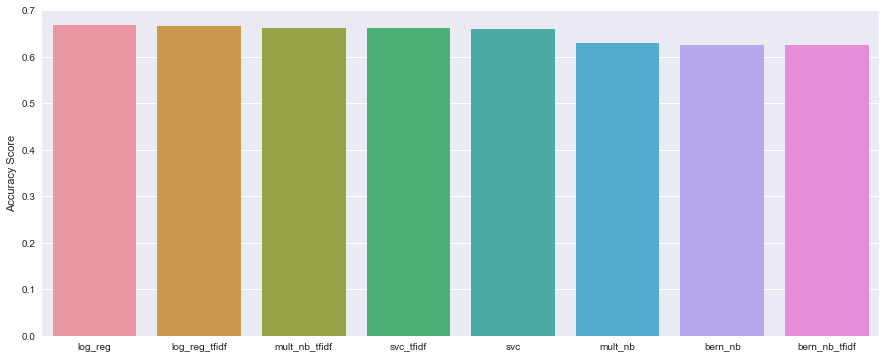

In [29]:
plt.figure(figsize=(15, 6))
sns.barplot(x=[name for name, _ in scores], y=[score for _, score in scores])
plt.ylabel('Accuracy Score')

Setup as a classification problem, sentiment towards the USA can be gleamed from a post with relative accuracy.